In [181]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from math import sin, cos, atan, radians, degrees

In [182]:
# The pacejka magic formula
def pacejkaMF(slip, B, C, D, E):
    '''
    slip = slip ratio (from -100 - 100), or angle (-90 to 90)
    B = define the width of the peak + how sharp it is
    C = define the height of the peak
    D = vertical scale of the shape
    E = how sharp it drops after peak
    '''
    Bx = B * slip
    return D * sin( C * atan( Bx - E * ( Bx - atan(Bx) ) ) )

# make sure it's correct
slip = 10.0 # 10% slip
B = 0.714
C = 1.325
D = 1.0
E = -0.2
p = pacejkaMF(slip, B, C, D, E)
print(f"Pacejka of slip={slip}, B({B}), C({C}), D({D}), E({E}) = {p:.2f}")

Pacejka of slip=10.0, B(0.714), C(1.325), D(1.0), E(-0.2) = 0.94


In [217]:
# let's graph it
pacejkaFV = np.vectorize(pacejkaMF)
slip_range = np.linspace(-100.0, 100.0, num=500)
W = 4500 # 4500 N

B = 0.914
C = 1.35
D = 1.0
E = -0.1

Flong = pacejkaFV(slip_range, B, C, W, E)
Flong_50 = pacejkaFV(slip_range, B, C, W*0.5, E)
Flong_25 = pacejkaFV(slip_range, B, C, W*0.25, E)
max_Flong = np.max(Flong)

result = np.where(Flong == max_Flong)
optimal_slip = slip_range[result[0]]

# for the lateral
slip_angle_range = np.linspace(-90.0, 90.0, num=500)

Blat = 0.714
Clat = 1.4
Dlat = 1.0
Elat = -0.0

Flat = pacejkaFV(slip_angle_range, Blat, Clat, W, Elat)
Flat_50 = pacejkaFV(slip_angle_range, Blat, Clat, W*0.5, Elat)
Flat_25 = pacejkaFV(slip_angle_range, Blat, Clat, W*0.25, Elat)
max_Flat = np.max(Flat)

result = np.where(Flat == max_Flat)
optimal_angle = slip_angle_range[result[0]]

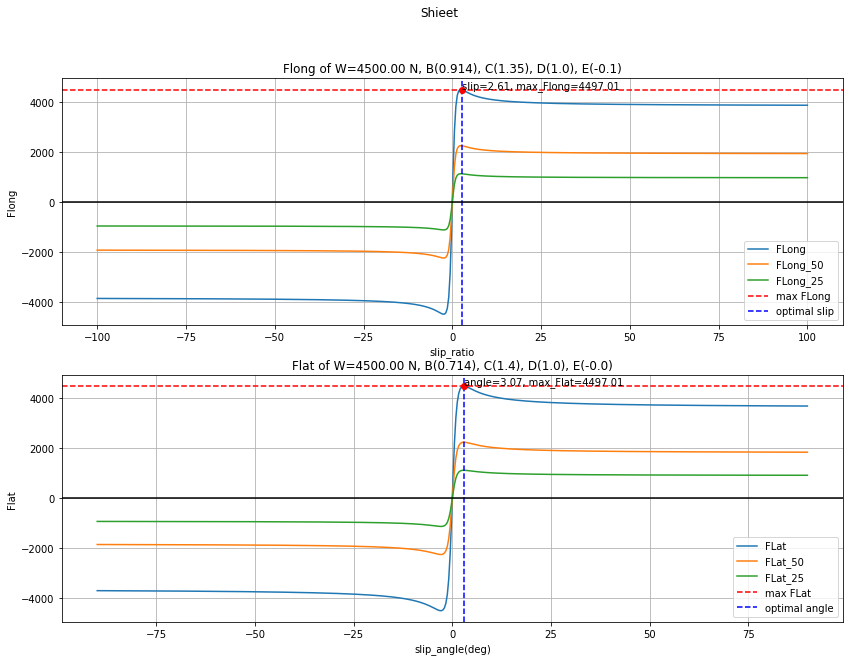

In [218]:
# fig = plt.figure('Pacejka Tire Calculator', figsize=(10, 6))
fig, axs = plt.subplots(2, figsize=(14,10))
fig.suptitle('Shieet')

# plot the function curve
axs[0].plot(slip_range, Flong, label='FLong')
axs[0].plot(slip_range, Flong_50, label='FLong_50')
axs[0].plot(slip_range, Flong_25, label='FLong_25')
# # plot the axis horizontal line for max_Flong
axs[0].axhline(max_Flong, color='r', linestyle='dashed', label='max FLong')
# # plot the vertical line for optimal slip
axs[0].axvline(optimal_slip, color='b', linestyle='dashed', label='optimal slip')

# # draw marker at maxima
axs[0].plot(optimal_slip, max_Flong, 'ro')
axs[0].text(optimal_slip, max_Flong + 64, "slip=%.2f, max_Flong=%.2f" % (optimal_slip, max_Flong) )

axs[0].set_title(f"Flong of W={W:.2f} N, B({B}), C({C}), D({D}), E({E})")
axs[0].set_xlabel('slip_ratio')
axs[0].set_ylabel('Flong')
# # zero axis
axs[0].axhline(0, color='k')
# # plt.axvline(0, color='k')
axs[0].grid()
axs[0].legend(loc='lower right')

# LATERAL VERSION
axs[1].plot(slip_angle_range, Flat, label='FLat')
axs[1].plot(slip_angle_range, Flat_50, label='FLat_50')
axs[1].plot(slip_angle_range, Flat_25, label='FLat_25')
# # plot the axis horizontal line for max_FLat
axs[1].axhline(max_Flat, color='r', linestyle='dashed', label='max FLat')
# # plot the vertical line for optimal slip
axs[1].axvline(optimal_angle, color='b', linestyle='dashed', label='optimal angle')

# # draw marker at maxima
axs[1].plot(optimal_angle, max_Flat, 'ro')
axs[1].text(optimal_angle, max_Flat + 64, "angle=%.2f, max_Flat=%.2f" % (optimal_angle, max_Flong) )

axs[1].set_title(f"Flat of W={W:.2f} N, B({Blat}), C({Clat}), D({Dlat}), E({Elat})")
axs[1].set_xlabel('slip_angle(deg)')
axs[1].set_ylabel('Flat')
# # zero axis
axs[1].axhline(0, color='k')
# # plt.axvline(0, color='k')
axs[1].grid()
axs[1].legend(loc='lower right')

plt.show()